In [2]:
import torch
import torch.nn as nn
from torch.cuda import Event
from tools.debug.logs import RedirectOutput
import matplotlib.pyplot as plt    

# Conclusion

**Modifications:**
- Merged QKV $\rightarrow$ Separate QKV
- Merged Gate/Up $\rightarrow$ Separate Gate/Up
- Triton RMSNorm $\rightarrow$ LLaMA RMSNorm
- Flash RoPR (training) $\rightarrow$ RoPE
- Interleaved RoPE $\rightarrow$ Non-interleaved RoPE
- Core attention $\rightarrow$ flash_attn_func
- Same computation device as transformers (CPU then CUDA)
- Fix RoPE precision bug (need to set the precision of the buffer)

**Questions:** Which one is better to keep? 

## TLDR

**Performance improvement**   
- Merged QKV and Gate_up projection only provide an improvement of less than or equal to **3%** and **0%** in TFLOPS, respectively, but they produce numerical differences         
- Triton RMSNorm provides a speedup of more than **10** times  
- Flash Rotary embedding also provides a speedup of more than **10** times    
Given batch_size = 8, and LLaMA-3 8b config, 
- Flash Rotary embedding/Triton RMSNorm saves $10^{-5}$ second for each forward, 
- Merged QKV only saves $10^{-7}$ second for each forward  

**Real bottleneck:**    
Asymptotically, FLOPs of LayerNorm is $O(d_{model})$, while there are components like the MLP that are $O(d_{model}^2)$.

With thousands times fewer FLOPs, however, the LayerNorm operation and Flash rotary embedding operation spend the same amount of time as MLP    

Given batch size = 8, sequence length = 8192    
TritonRMSNorm time: 3e-4 seconds per run, TFLOPS: 4.43   
RMSNorm time: **4e-3** seconds per run, TFLOPS: 0.38    

FlashRotaryEmbedding time: 5e-4 seconds per run
LlamaRotaryEmbedding time: **6e-3** seconds per run

Separate QKV time: 5e-3 seconds per run, TFLOPS: 633.62   
Merged QKV time: **5e-3** seconds per run, TFLOPS: 643.98   

# Helper function

In [3]:
# Benchmarking
def benchmark(model, *args, n_runs=100, warm_up=20):
    for _ in range(warm_up):
        _ = model(*args)
    
    # Benchmark
    start_event = Event(enable_timing=True)
    end_event = Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    
    for _ in range(n_runs):
        _ = model(*args)
    
    end_event.record()
    torch.cuda.synchronize()
    
    return start_event.elapsed_time(end_event) / n_runs / 1000

# QKV projection

In [4]:
# Separate Q, K, V Projections
class SeparateQKV(nn.Module):
    def __init__(self, d_model, num_attention_heads, num_key_values):
        super(SeparateQKV, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.num_key_values = num_key_values
        self.d_k = d_model // num_attention_heads
        self.W_q = nn.Linear(d_model, num_attention_heads * d_k)
        self.W_k = nn.Linear(d_model, num_key_values * d_k)
        self.W_v = nn.Linear(d_model, num_key_values * d_k)

    def forward(self, x):
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        return None

# Merged QKV Projection
class MergedQKV(nn.Module):
    def __init__(self, d_model, num_attention_heads, num_key_values):
        super(MergedQKV, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.num_key_values = num_key_values
        self.d_k = d_model // num_attention_heads
        self.W_qkv = nn.Linear(d_model, (num_attention_heads + 2 * num_key_values) * d_k)

    def forward(self, x):
        qkv = self.W_qkv(x)
        q, k, v = torch.split(qkv,
            [
                self.num_attention_heads * self.d_k,
                self.num_key_values * self.d_k,
                self.num_key_values * self.d_k,
            ],
            dim=-1,
        )
        return None

In [5]:
# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
seven_b_llama = True
batch_size = 8
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

# Input tensor
x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

# Initialize models
separate_qkv = SeparateQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()
merged_qkv = MergedQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()

# Run benchmarks
n_runs = 400

time_separate = benchmark(separate_qkv, x, n_runs=n_runs)
time_merged = benchmark(merged_qkv, x, n_runs=n_runs)

TFLOPS = 2 * batch_size * seq_len * d_model * (num_attention_heads + 2 * num_key_values) * d_k / 1e12

print(f"Separate QKV time: {time_separate:.6f} seconds per run, TFLOPS: {TFLOPS / time_separate:.2f}")
print(f"Merged QKV time: {time_merged:.6f} seconds per run, TFLOPS: {TFLOPS / time_merged:.2f}")
print(f"Speedup: {time_separate / time_merged:.2f}x")

Separate QKV time: 0.005141 seconds per run, TFLOPS: 641.62
Merged QKV time: 0.005099 seconds per run, TFLOPS: 646.85
Speedup: 1.01x


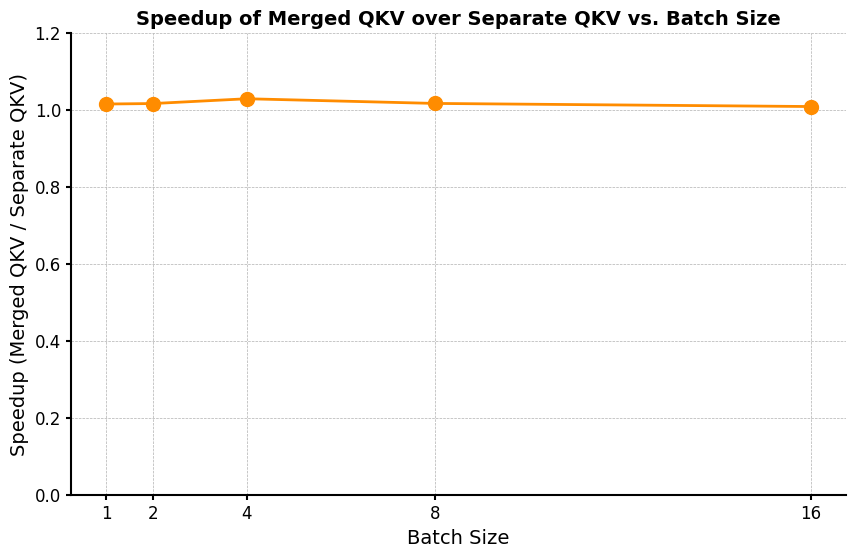

In [6]:
def benchmark_qkv(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    seven_b_llama = True
    # Parameters
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    num_attention_heads = 32 if seven_b_llama else 64
    num_key_values = 8
    d_k = d_model // num_attention_heads
    
    speedups = []

    print("Sequence length = {}, d_model = {}, num_attention_heads = {}, num_key_values = {}".format(seq_len, d_model, num_attention_heads, num_key_values))
    
    # Initialize models
    separate_qkv = SeparateQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()
    merged_qkv = MergedQKV(d_model, num_attention_heads, num_key_values).to(device).bfloat16()
    
    for batch_size in batch_sizes:
        # Input tensor
        x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

        # Run benchmarks
        n_runs = 600

        time_separate = benchmark(separate_qkv, x, n_runs=n_runs)
        time_merged = benchmark(merged_qkv, x, n_runs=n_runs)
        
        speedups.append(time_separate / time_merged)

        TFLOPS = 2 * batch_size * seq_len * d_model * (num_attention_heads + 2 * num_key_values) * d_k / 1e12

        print(f"batch size = {batch_size}")
        print(f"Separate QKV time: {time_separate:.6f} seconds per run, TFLOPS: {TFLOPS / time_separate:.2f}")
        print(f"Merged QKV time: {time_merged:.6f} seconds per run, TFLOPS: {TFLOPS / time_merged:.2f}")
        print(f"Speedup: {time_separate / time_merged:.2f}x")
        print(f"Time per run: {time_merged:.6f}, {time_separate:.6f}")
        print(f"Time saving per run: {(time_separate - time_merged)/n_runs:.8f} seconds")
        print()
    return speedups

batch_sizes = [1, 2, 4, 8, 16]        
with RedirectOutput("../../.cache/logs/benchmark/benchmark_qkv.txt"):
    speedups = benchmark_qkv(batch_sizes)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, speedups, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup (Merged QKV / Separate QKV)', fontsize=14)
plt.title('Speedup of Merged QKV over Separate QKV vs. Batch Size', fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.2)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)
plt.show()    

# Gate/UP projection

In [7]:
class SeparateGateUp(nn.Module):
    def __init__(self, d_model, intermediate_dim):
        super(SeparateGateUp, self).__init__()
        self.W_gate = nn.Linear(d_model, intermediate_dim)
        self.W_up = nn.Linear(d_model, intermediate_dim)

    def forward(self, x):
        gate = self.W_gate(x)
        up = self.W_up(x)
        return gate, up

# Merged Gate/Up Projection
class MergedGateUp(nn.Module):
    def __init__(self, d_model, intermediate_dim):
        super(MergedGateUp, self).__init__()
        self.W_gate_up = nn.Linear(d_model, intermediate_dim + intermediate_dim)
        self.intermediate_dim = intermediate_dim

    def forward(self, x):
        gate_up = self.W_gate_up(x)
        gate, up = torch.split(gate_up, [self.intermediate_dim, self.intermediate_dim], dim=-1)
        return gate, up

In [8]:
# Separate Gate/Up Projections
intermediate_dim = 14336 

# Initialize models
separate_gate_up = SeparateGateUp(d_model, intermediate_dim).to(device).bfloat16()
merged_gate_up = MergedGateUp(d_model, intermediate_dim).to(device).bfloat16()

# Run benchmarks
n_runs = 50
time_separate = benchmark(separate_gate_up, x, n_runs=n_runs)
time_merged = benchmark(merged_gate_up, x, n_runs=n_runs)

flops = 2 * batch_size * seq_len * d_model * (intermediate_dim * 2) / 1e12

print(f"Separate Gate/Up time: {time_separate:.6f} seconds per run, TFLOPs: {(flops  / time_separate):.2f}")
print(f"Merged Gate/Up time: {time_merged:.6f} seconds per run, TFLOPs: {(flops  / time_merged):.2f}")
print(f"Speedup: {time_separate / time_merged:.2f}x")

Separate Gate/Up time: 0.023737 seconds per run, TFLOPs: 648.49
Merged Gate/Up time: 0.023896 seconds per run, TFLOPs: 644.18
Speedup: 0.99x


In [9]:
def benchmark_gate_up(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    seven_b_llama = True
    # Parameters
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    intermediate_dim = 14336

    print("Sequence length = {}, d_model = {}, intermediate_dim = {}".format(seq_len, d_model, intermediate_dim))
    
    # Initialize models
    separate_gate_up = SeparateGateUp(d_model, intermediate_dim).to(device).bfloat16()
    merged_gate_up = MergedGateUp(d_model, intermediate_dim).to(device).bfloat16()
    
    speedups = []
    
    for batch_size in batch_sizes:
        # Input tensor
        x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

        # Run benchmarks
        n_runs = 100

        time_separate = benchmark(separate_gate_up, x, n_runs=n_runs)
        time_merged = benchmark(merged_gate_up, x, n_runs=n_runs)
        
        speedups.append(time_separate / time_merged)

        flops = 2 * batch_size * seq_len * d_model * (intermediate_dim * 2) / 1e12

        print(f"batch size = {batch_size}")
        print(f"Separate Gate/Up time: {time_separate:.6f} seconds per run, TFLOPs: {(flops  / time_separate):.2f}")
        print(f"Merged Gate/Up time: {time_merged:.6f} seconds per run, TFLOPs: {(flops  / time_merged):.2f}")
        print(f"Speedup: {time_separate / time_merged:.2f}x")
        print(f"Time per run: {time_merged:.6f}, {time_separate:.6f}")
        print()
    return speedups
        
with RedirectOutput("../../.cache/logs/benchmark/benchmark_gate_up.txt"):
    speedups = benchmark_gate_up([1,2,4,8,16])

# Flash attention

In [18]:
from flash_attn.flash_attn_interface import flash_attn_func
import torch.nn.functional as F

causal = True

# Flash Attention
def flash_attention(q, k, v):
    # Flash Attention expects inputs in the shape (batch_size, seq_len, num_heads, head_dim)
    return flash_attn_func(q, k, v, causal=causal)

# Scaled Dot-Product Attention
def sdpa(q, k, v):
    return F.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=causal)

In [20]:
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
k = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)
v = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)

n_runs = 100
time_flash = benchmark(flash_attention, q, k, v, n_runs=n_runs)

# SDPA expects inputs in the shape (batch_size, num_heads, seq_len, head_dim)
q = q.transpose(1, 2)
k = k.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)
v = v.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)

time_sdpa = benchmark(sdpa, q, k, v, n_runs=n_runs)

# Note: This FLOPS calculation is an approximation and might need adjustment
TFLOPS = 4 * batch_size * (seq_len ** 2) * num_attention_heads * d_k / 1e12 

if causal:
    TFLOPS /=2

print(f"Flash Attention time: {time_flash:.6f} seconds per run, TFLOPS: {TFLOPS / time_flash:.2f}")
print(f"SDPA time: {time_sdpa:.6f} seconds per run, TFLOPS: {TFLOPS / time_sdpa:.2f}")
print(f"Speedup: {time_sdpa / time_flash:.2f}x")

Flash Attention time: 0.012597 seconds per run, TFLOPS: 349.12
SDPA time: 0.025028 seconds per run, TFLOPS: 175.73
Speedup: 1.99x


In [21]:
def benchmark_attention(batch_sizes):
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    num_attention_heads = 32 if seven_b_llama else 64
    num_key_values = 8
    d_k = d_model // num_attention_heads
    print("Sequence length = {}, d_model = {}, num_attention_heads = {}, num_key_values = {}".format(seq_len, d_model, num_attention_heads, num_key_values))
    for batch_size in batch_sizes:
        q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        k = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)
        v = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)

        n_runs = 100
        time_flash = benchmark(flash_attention, q, k, v, n_runs=n_runs)

        # SDPA expects inputs in the shape (batch_size, num_heads, seq_len, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)
        v = v.transpose(1, 2).repeat_interleave(num_attention_heads//num_key_values, dim=1)

        time_sdpa = benchmark(sdpa, q, k, v, n_runs=n_runs)

        # Note: This FLOPS calculation is an approximation and might need adjustment
        TFLOPS = 4 * batch_size * (seq_len ** 2) * num_attention_heads * d_k / 1e12

        if causal:
            TFLOPS /=2
        
        print(f"batch size = {batch_size}")
        print(f"Flash Attention time: {time_flash:.6f} seconds per run, TFLOPS: {TFLOPS / time_flash:.2f}")
        print(f"SDPA time: {time_sdpa:.6f} seconds per run, TFLOPS: {TFLOPS / time_sdpa:.2f}")
        print(f"Speedup: {time_sdpa / time_flash:.2f}x")
        print()

In [22]:
with RedirectOutput("../../.cache/logs/benchmark/benchmark_attention.txt"):
    benchmark_attention([1,2,4,8,16])

# Triton RMSNorm

In [11]:
import torch
from torch import nn
from flash_attn.ops.triton.layer_norm import layer_norm_fn

class TritonRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5, device=None, dtype=None):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.empty(hidden_size, **factory_kwargs))
        self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.ones_(self.weight)

    def forward(
        self, input, residual=None, dropout_p=0.0, prenorm=False, residual_in_fp32=False, return_dropout_mask=False
    ):
        return layer_norm_fn(
            input,
            self.weight,
            None,
            residual=residual,
            eps=self.eps,
            dropout_p=dropout_p,
            prenorm=prenorm,
            residual_in_fp32=residual_in_fp32,
            is_rms_norm=True,
            return_dropout_mask=return_dropout_mask,
        )


# equivalent to TritonRMSNorm
class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        """
        LlamaRMSNorm is equivalent to T5LayerNorm
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, input):
        input_dtype = input.dtype
        input = input.to(torch.float32)
        variance = input.pow(2).mean(-1, keepdim=True)
        input = input * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * input.to(input_dtype)


In [12]:
# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
seven_b_llama = True
batch_size = 8
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

# Input tensor
x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

# Initialize models
triton_rmsnorm = TritonRMSNorm(d_model).to(device)
rmsnorm = RMSNorm(d_model).to(device)

In [54]:
# Run benchmarks
n_runs = 400
time_triton_rmsnorm = benchmark(triton_rmsnorm, x, n_runs=n_runs)
time_rmsnorm = benchmark(rmsnorm, x, n_runs=n_runs)

print(f"TritonRMSNorm time: {time_triton_rmsnorm:.6f} seconds per run")
print(f"RMSNorm time: {time_rmsnorm:.6f} seconds per run")
print(f"Speedup: {time_rmsnorm / time_triton_rmsnorm:.2f}x")

TritonRMSNorm time: 0.000359 seconds per run
RMSNorm time: 0.004598 seconds per run
Speedup: 12.82x


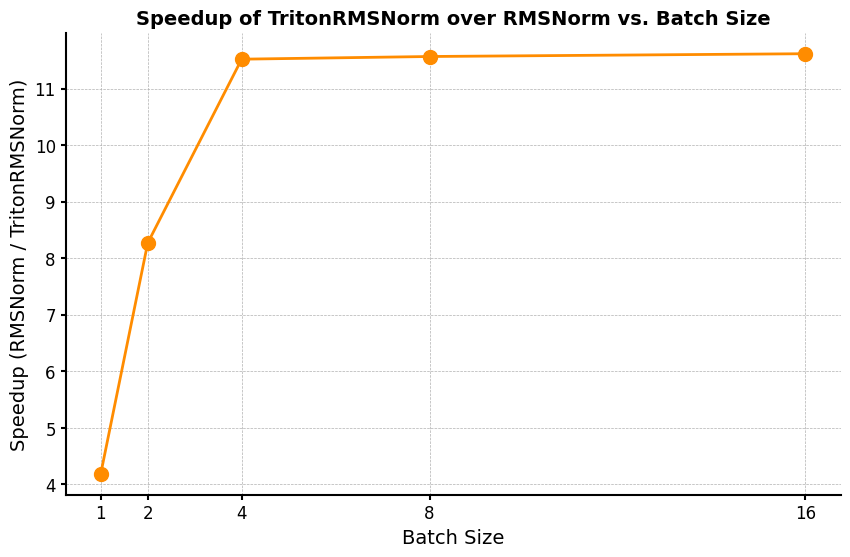

In [13]:

def benchmark_layernorm(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    seven_b_llama = True
    # Parameters
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    

    print(f"Sequence length = {seq_len}, d_model = {d_model}")
    
    # Initialize models
    triton_rmsnorm = TritonRMSNorm(d_model).to(device).bfloat16()
    rmsnorm = RMSNorm(d_model).to(device).bfloat16()
    
    speedups = []

    for batch_size in batch_sizes:
        # Input tensor
        x = torch.randn(batch_size * seq_len, d_model, dtype=torch.bfloat16, device=device)

        # Run benchmarks
        n_runs = 400

        time_triton_rmsnorm = benchmark(triton_rmsnorm, x, n_runs=n_runs)
        time_rmsnorm = benchmark(rmsnorm, x, n_runs=n_runs)
        
        speedups.append(time_rmsnorm / time_triton_rmsnorm)

        TFLOPS = 6 * batch_size * seq_len * d_model / 1e12

        print(f"batch size = {batch_size}")
        print(f"TritonRMSNorm time: {time_triton_rmsnorm:.6f} seconds per run, TFLOPS: {TFLOPS / time_triton_rmsnorm:.2f}")
        print(f"RMSNorm time: {time_rmsnorm:.6f} seconds per run, TFLOPS: {TFLOPS / time_rmsnorm:.2f}")
        print(f"Speedup: {time_rmsnorm / time_triton_rmsnorm:.2f}x")
        print(f"Time per run: {time_triton_rmsnorm:.6f}, {time_rmsnorm:.6f}")
        print(f"Time saving per run: {(time_rmsnorm - time_triton_rmsnorm)/n_runs:.6f} seconds")
        print()
        
    return speedups

batch_sizes = [1, 2, 4, 8, 16]
with RedirectOutput("../../.cache/logs/benchmark/benchmark_layernorm.txt"):
    speedups = benchmark_layernorm(batch_sizes)
    
import matplotlib.pyplot as plt    

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, speedups, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup (RMSNorm / TritonRMSNorm)', fontsize=14)
plt.title('Speedup of TritonRMSNorm over RMSNorm vs. Batch Size', fontsize=14, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)
plt.show()

# Flash RoPE

In [4]:
from typing import Optional
from flash_attn.layers.rotary import RotaryEmbedding as FlashRotaryEmbedding

## Copy from transformers. Non interleaved version of RoPE. Will be refactored later
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim: int, end: int, theta: float = 500000.0):
        super().__init__()
        self.dim = dim
        self.end = end
        self.theta = theta
        self.init_rotary_embeddings()

    def init_rotary_embeddings(self):
        inv_freq = 1.0 / (
            self.theta ** (torch.arange(0, self.dim, 2, dtype=torch.float, device="cpu") / self.dim)
        )  # important to compute on CPU
        # inv_freq = apply_scaling(inv_freq)  # if LLaMA 3.1
        self.register_buffer(
            "inv_freq", torch.empty(self.dim // 2, dtype=torch.float, device="cuda"), persistent=False
        )
        self.inv_freq = self.inv_freq.to(
            torch.float
        )  # make it float32 before copy to avoid precision loss during copy_
        self.inv_freq.copy_(inv_freq)

        saved_inv_freq = torch.load("/fsx/haojun/LLaMA/.cache/activation_values/inv_freq.pt")
        assert torch.equal(self.inv_freq.cpu(), saved_inv_freq), "inv_freq mismatch."

    @torch.no_grad()
    def forward(
        self,
        x: torch.Tensor,  # [batch_size, seq_length, num_heads, d_qk]
        position_ids: Optional[torch.LongTensor],  # [batch_size, seq_length]
    ):
        # x: [bs, num_attention_heads, seq_len, head_size]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        position_ids_expanded = position_ids[:, None, :].float()
        # Force float32 since bfloat16 loses precision on long contexts
        # See https://github.com/huggingface/transformers/pull/29285
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            emb = torch.cat((freqs, freqs), dim=-1)
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=2):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


# Define the benchmark function
def benchmark_rotary(rotary_embedding, apply_rotary_pos_emb, q, k, v, position_ids, n_runs=100, warm_up=20):
    # Warm-up phase
    for _ in range(warm_up):
        cos, sin = rotary_embedding(v, position_ids)
        _ = apply_rotary_pos_emb(q, k, cos, sin)
    
    # Benchmark phase
    start_event = Event(enable_timing=True)
    end_event = Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    
    for _ in range(n_runs):
        cos, sin = rotary_embedding(v, position_ids)
        _ = apply_rotary_pos_emb(q, k, cos, sin)
    
    end_event.record()
    torch.cuda.synchronize()
    
    # Return the average time per run in seconds
    return start_event.elapsed_time(end_event) / n_runs / 1000

# Setup
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seven_b_llama = True
batch_size = 8
seq_len = 8192
d_model = 4096 if seven_b_llama else 8192
num_attention_heads = 32 if seven_b_llama else 64
num_key_values = 8
d_k = d_model // num_attention_heads

q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
k = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)
v = torch.randn(batch_size, seq_len, num_key_values, d_k, dtype=torch.bfloat16, device=device)

rotary_embedding = LlamaRotaryEmbedding(dim=d_k, end=seq_len, theta=500000).to(device).bfloat16()
flash_rotary_embedding = FlashRotaryEmbedding(dim=d_k, interleaved=False, base=500000).to(device)

position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

# Benchmark Llama Rotary Embedding
time_llama_rotary_embedding = benchmark_rotary(rotary_embedding, apply_rotary_pos_emb, q, k, v, position_ids, n_runs=400)

# If you want to benchmark the FlashRotaryEmbedding as well, you can define another benchmark function or adjust the existing one.
# Here’s an example if you want to benchmark the FlashRotaryEmbedding directly:
def benchmark_flash(model, q, kv, n_runs=100, warm_up=20):
    for _ in range(warm_up):
        _ = model(q, kv)
    
    # Benchmark
    start_event = Event(enable_timing=True)
    end_event = Event(enable_timing=True)
    
    torch.cuda.synchronize()
    start_event.record()
    
    for _ in range(n_runs):
        _ = model(q, kv)
    
    end_event.record()
    torch.cuda.synchronize()
    
    return start_event.elapsed_time(end_event) / n_runs / 1000

k = k.unsqueeze(2)
v = v.unsqueeze(2)
kv = torch.cat((k, v), dim=2)

time_flash_rotary_embedding = benchmark_flash(flash_rotary_embedding, q, kv, n_runs=400)

# Print the results
print(f"LlamaRotaryEmbedding time: {time_llama_rotary_embedding:.6f} seconds per run")
print(f"FlashRotaryEmbedding time: {time_flash_rotary_embedding:.6f} seconds per run")
print(f"Speedup: {time_llama_rotary_embedding / time_flash_rotary_embedding:.2f}x")


LlamaRotaryEmbedding time: 0.004450 seconds per run
FlashRotaryEmbedding time: 0.000582 seconds per run
Speedup: 7.64x


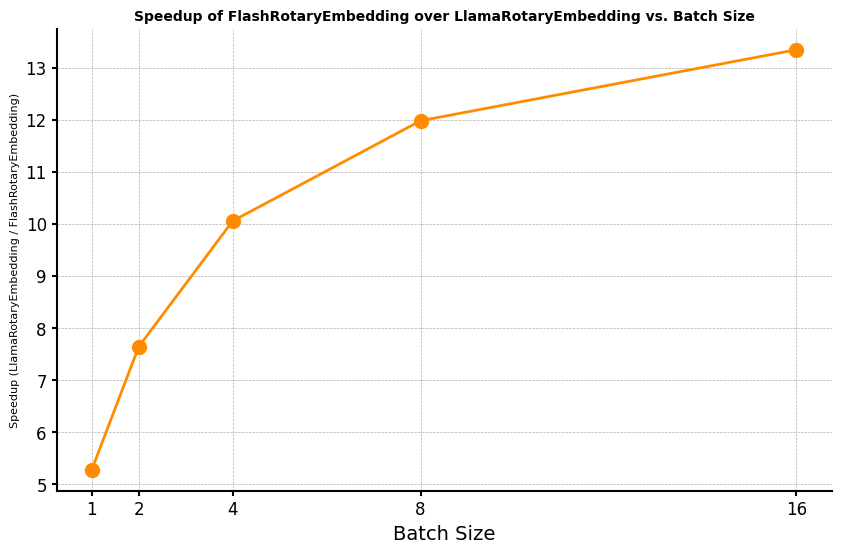

In [6]:
import torch
from torch.cuda import Event
import matplotlib.pyplot as plt

def benchmark_rope(batch_sizes):
    # Setup
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    seven_b_llama = True
    seq_len = 8192
    d_model = 4096 if seven_b_llama else 8192
    num_attention_heads = 32 if seven_b_llama else 64
    d_k = d_model // num_attention_heads

    print(f"Sequence length = {seq_len}, d_model = {d_model}")
    
    # Initialize rotary embeddings
    rotary_embedding = LlamaRotaryEmbedding(dim=d_k, end=seq_len, theta=500000).to(device).bfloat16()
    flash_rotary_embedding = FlashRotaryEmbedding(dim=d_k, interleaved=False, base=500000).to(device)
    
    speedups = []

    for batch_size in batch_sizes:
        # Generate input tensors
        q = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        k = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        v = torch.randn(batch_size, seq_len, num_attention_heads, d_k, dtype=torch.bfloat16, device=device)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)

        # Run benchmarks
        n_runs = 400

        time_llama_rotary = benchmark_rotary(rotary_embedding, apply_rotary_pos_emb, q, k, v, position_ids, n_runs=n_runs)
        time_flash_rotary = benchmark_flash(flash_rotary_embedding, q, kv, n_runs=n_runs)
        
        speedups.append(time_llama_rotary / time_flash_rotary)

        TFLOPS = 6 * batch_size * seq_len * d_model / 1e12

        print(f"Batch size = {batch_size}")
        print(f"LlamaRotaryEmbedding time: {time_llama_rotary:.6f} seconds per run, TFLOPS: {TFLOPS / time_llama_rotary:.2f}")
        print(f"FlashRotaryEmbedding time: {time_flash_rotary:.6f} seconds per run, TFLOPS: {TFLOPS / time_flash_rotary:.2f}")
        print(f"Speedup: {time_llama_rotary / time_flash_rotary:.2f}x")
        print(f"Time per run: {time_llama_rotary:.6f}, {time_flash_rotary:.6f}")
        print(f"Time saving per run: {(time_llama_rotary - time_flash_rotary)/n_runs:.6f} seconds")
        print()
        
    return speedups

batch_sizes = [1, 2, 4, 8, 16]

with RedirectOutput("../../.cache/logs/benchmark/benchmark_rope.txt"):
    speedups = benchmark_rope(batch_sizes)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, speedups, marker='o', linestyle='-', color='darkorange', linewidth=2, markersize=10)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Speedup (LlamaRotaryEmbedding / FlashRotaryEmbedding)', fontsize=8)
plt.title('Speedup of FlashRotaryEmbedding over LlamaRotaryEmbedding vs. Batch Size', fontsize=10, fontweight='bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(batch_sizes, fontsize=12)
plt.yticks(fontsize=12)

# Adding some style to the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().tick_params(width=1.5)
plt.show()